## Data Collection

In [177]:
# Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import MarkerCluster, FastMarkerCluster

from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split

# pandas options
pd.set_option('display.max_columns', 200)

In [147]:
data = pd.read_csv('../raw/AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Exploratory and Data Cleaning

In [148]:
# Dimension and data types
print(data.shape)
data.info()

(48895, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review         

We can observe:

  - 48.895 listing of Airbnb.

  - Categorical Variables: **8**.

  - Numeric Variables: **8**.

### Visual Exploration of Locations

In [149]:
# Aprox. longitude and latitute to see locations in NYC
latitude = 40.80
longitude = -73.80

locations = list(zip(data['latitude'], data['longitude']))

mapa = folium.Map(
  location = [latitude, longitude],
  zoom_start = 10
)

FastMarkerCluster(data = locations).add_to(mapa)

mapa

### Check for duplicates

In [150]:
for columnas in data.columns:
  print(f'Number of duplicates in `{columnas}` is: ', data[columnas].duplicated().sum())

Number of duplicates in `id` is:  0
Number of duplicates in `name` is:  989
Number of duplicates in `host_id` is:  11438
Number of duplicates in `host_name` is:  37442
Number of duplicates in `neighbourhood_group` is:  48890
Number of duplicates in `neighbourhood` is:  48674
Number of duplicates in `latitude` is:  29847
Number of duplicates in `longitude` is:  34177
Number of duplicates in `room_type` is:  48892
Number of duplicates in `price` is:  48221
Number of duplicates in `minimum_nights` is:  48786
Number of duplicates in `number_of_reviews` is:  48501
Number of duplicates in `last_review` is:  47130
Number of duplicates in `reviews_per_month` is:  47957
Number of duplicates in `calculated_host_listings_count` is:  48848
Number of duplicates in `availability_365` is:  48529


Principal things I can observe is:

  - `id` has no duplicates, which is expected as it should be unique identifier for each entry.

  - `neighbourhood` and `room_type` have the highest number of duplicates, indicating these fields are often repeated across entries.

  - `name`, `host_id` and `price` have fewer duplicates, indicating more variability in these attributes.

### Check for null values

In [151]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [152]:
# Check the null values as a % to see the real impact
100 * data.isnull().sum() / len(data)

id                                 0.000000
name                               0.032723
host_id                            0.000000
host_name                          0.042949
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.558339
reviews_per_month                 20.558339
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

- `name` and `host_name` have low percentage of null values.

- `last_review` and `reviews_per_mont` have a significant percentage of null values.

### Eliminate irrelevant information

In [153]:
# Variables to be eliminated
drop_list = ['id', 'name', 'host_name', 'last_review', 'reviews_per_month']

In [154]:
# drop
data.drop(labels = drop_list, axis = 1, inplace = True)

In [155]:
# Check update data
data.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


## Analysis of Univariate Variables

### Analysis on Categorical Variables

In [156]:
# Categorical Variables
categorical_variables = ['host_id', 'neighbourhood_group', 'neighbourhood', 'room_type', 'availability_365']

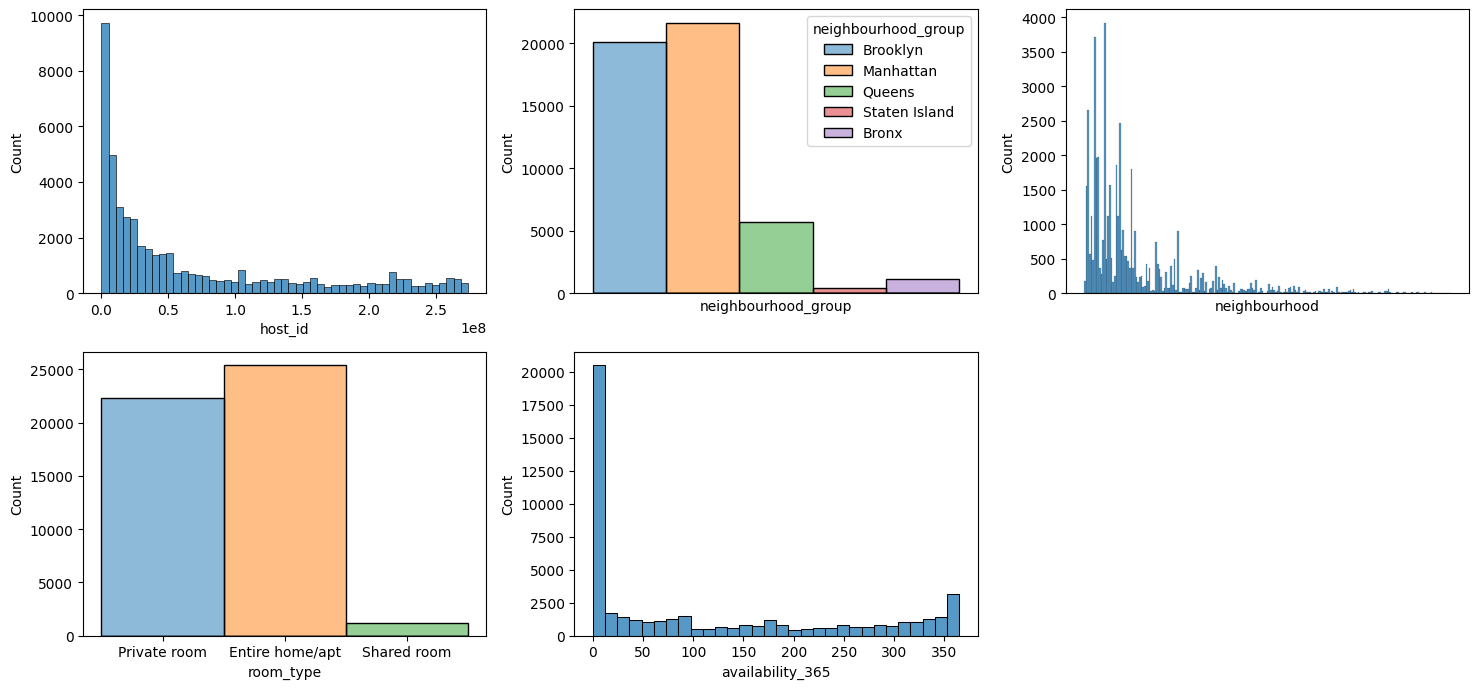

In [157]:
fig, axis = plt.subplots(2, 3, figsize = (15, 7))

# Create histograms
sns.histplot(data, ax = axis[0, 0], x = categorical_variables[0])
sns.histplot(data, ax = axis[0, 1], x = categorical_variables[1], hue = categorical_variables[1]).set_xticks([])
sns.histplot(data, ax = axis[0, 2], x = categorical_variables[2]).set_xticks([])
sns.histplot(data, ax = axis[1, 0], x = categorical_variables[3], hue = categorical_variables[3], legend = False)
sns.histplot(data, ax = axis[1, 1], x = categorical_variables[4])

# adjust the layout
plt.tight_layout()

# Eliminate a plot
plt.delaxes(axis[1, 2])

# show plot
plt.show()

We can observe that:

  - The first graph has a leftward trend, indicating that most hosts have few listings, while a few have many listings.

  - In the second graph, we can see an imbalance, as there is a higher presence of listings in the Manhattan area, followed by Brooklyn, and then Staten Island.

  - In the third graph, I see again a leftward trend with a higher presence of listings mainly in the neighborhoods of Williamsburg, Bedford-Stuyvesant, Harlem, Bushwick, and Upper West Side.

  - In the fourth graph, we again witness an imbalance with a higher presence of entire apartment listings, followed by private rooms, and lastly shared rooms.

  - In the fifth graph, we can see the availability of properties throughout the year.

### Analysis of Numerical Variables

In [158]:
data.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


In [159]:
# Numerical Variables
numerical_variables = ['price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count']

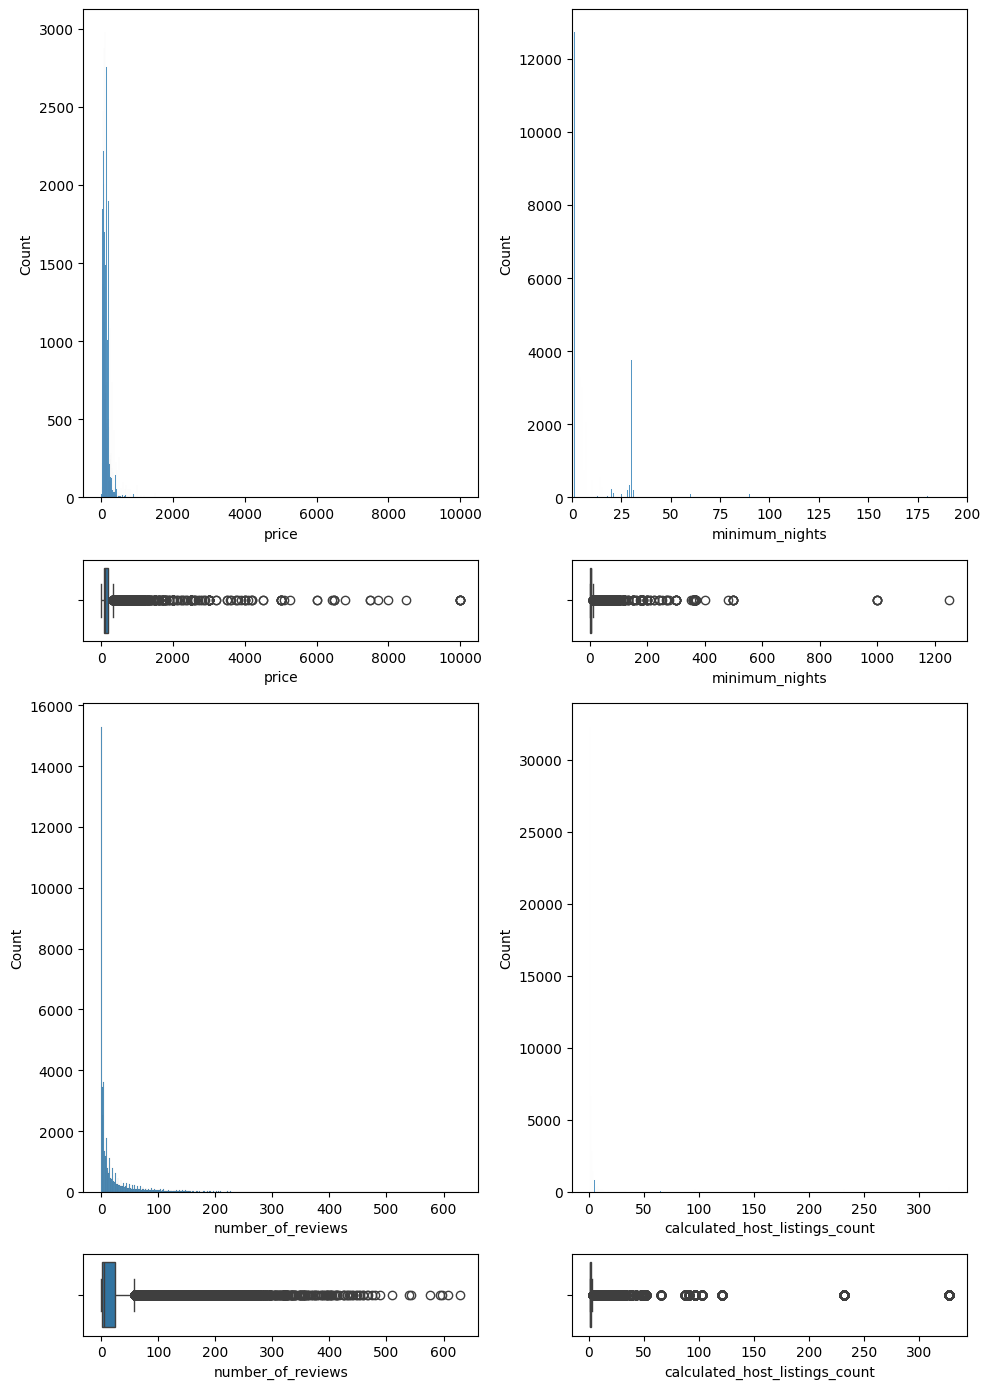

In [160]:
fig, axis = plt.subplots(4, 2, figsize = (10, 14), gridspec_kw = {"height_ratios": [6, 1, 6, 1]})

sns.histplot(ax = axis[0, 0], x = numerical_variables[0], data = data)
sns.boxplot(ax = axis[1, 0], x = numerical_variables[0], data = data)

sns.histplot(ax = axis[0, 1], x = numerical_variables[1], data = data).set_xlim(0, 200)
sns.boxplot(ax = axis[1, 1], x = numerical_variables[1], data = data)

sns.histplot(ax = axis[2, 0], x = numerical_variables[2], data = data)
sns.boxplot(ax = axis[3, 0], x = numerical_variables[2], data = data)

sns.histplot(ax = axis[2,1], x = numerical_variables[3], data = data)
sns.boxplot(ax = axis[3, 1], x = numerical_variables[3], data = data)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Analysis of multivariate variables (Target Variable)

### Numerical - Numerical analysis

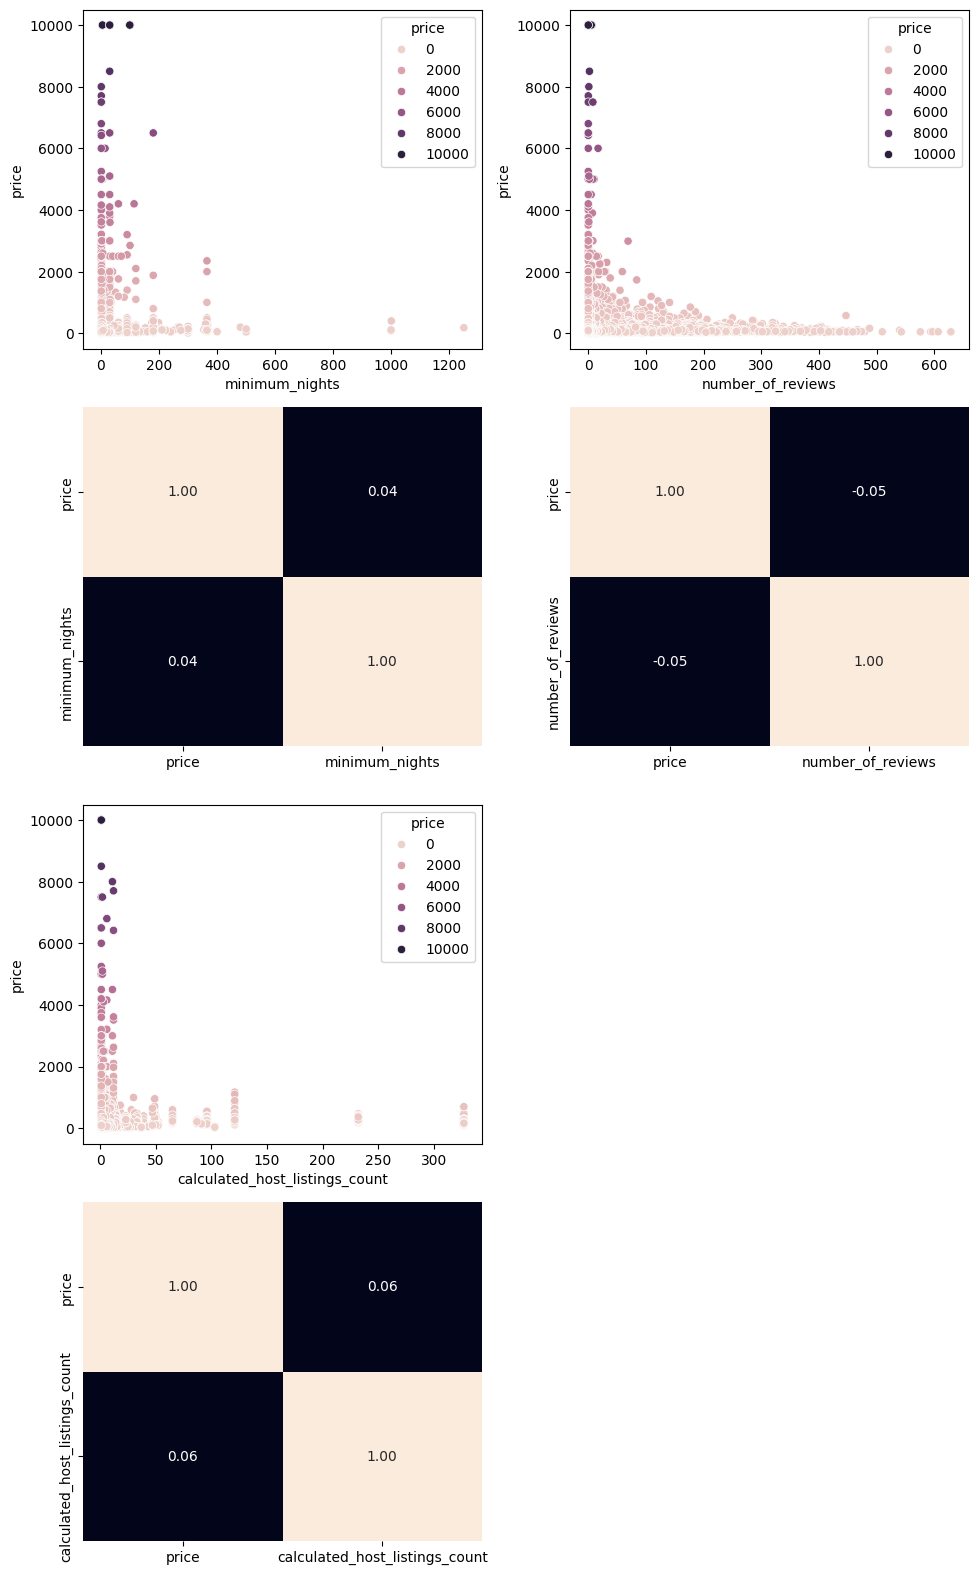

In [161]:
# numerical_variables = ['price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count']

# target
target = 'price'

# Create subplots
fig, axis = plt.subplots(4, 2, figsize = (10, 16))

# price - minimun_nights
sns.scatterplot(data, ax = axis[0, 0], x = numerical_variables[1], y = target, hue = target)
sns.heatmap(data[[target, numerical_variables[1]]].corr(), annot = True, fmt = '.2f', ax = axis[1, 0], cbar = False)

# price - number_of_reviews
sns.scatterplot(data, ax = axis[0, 1], x = numerical_variables[2], y = target, hue = target)
sns.heatmap(data[[target, numerical_variables[2]]].corr(), annot = True, fmt = '.2f', ax = axis[1, 1], cbar = False)

# price - calculated_host_listings_count
sns.scatterplot(data, ax = axis[2, 0], x = numerical_variables[3], y = target, hue = target)
sns.heatmap(data[[target, numerical_variables[3]]].corr(), annot = True, fmt = '.2f', ax = axis[3, 0], cbar = False)

plt.tight_layout()

plt.delaxes(ax = axis[3,1])
plt.delaxes(ax = axis[2,1])

plt.show()

- Target variable (`price`) has no direct relationship between `minimum_nights` `number_of_reviews` and `calculated_host_listings_count`

### Categorical - Categorical analysis

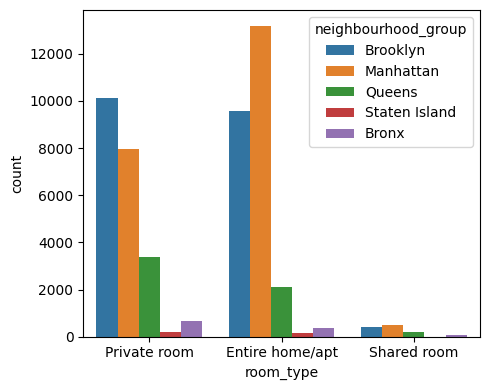

In [162]:
fig, axis = plt.subplots(figsize = (5, 4))

sns.countplot(data, x = 'room_type', hue = 'neighbourhood_group')

plt.tight_layout()

plt.show()

Principal observations:

  - `Manhattan` has the highest count of 'Entire home/apt' significantly more than any other category or neighbourhood.

  - `Brooklyn` leads in the category of 'Private room'.

  - The other neighbourhood, have considerably lower counts across all room types.

### Numerical - Categorical analysis

In [163]:
data.drop(['host_id', 'latitude', 'longitude'], axis = 1, inplace = True)

In [164]:
# Factorize the Room Type and Neighbourhood Data
data['neighbourhood'] = pd.factorize(data['neighbourhood'])[0]
data['neighbourhood_group'] = pd.factorize(data['neighbourhood_group'])[0]
data['room_type'] = pd.factorize(data['room_type'])[0]

In [165]:
data.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,0,0,0,149,1,9,6,365
1,1,1,1,225,1,45,2,355
2,1,2,0,150,3,0,1,365
3,0,3,1,89,1,270,1,194
4,1,4,1,80,10,9,1,0


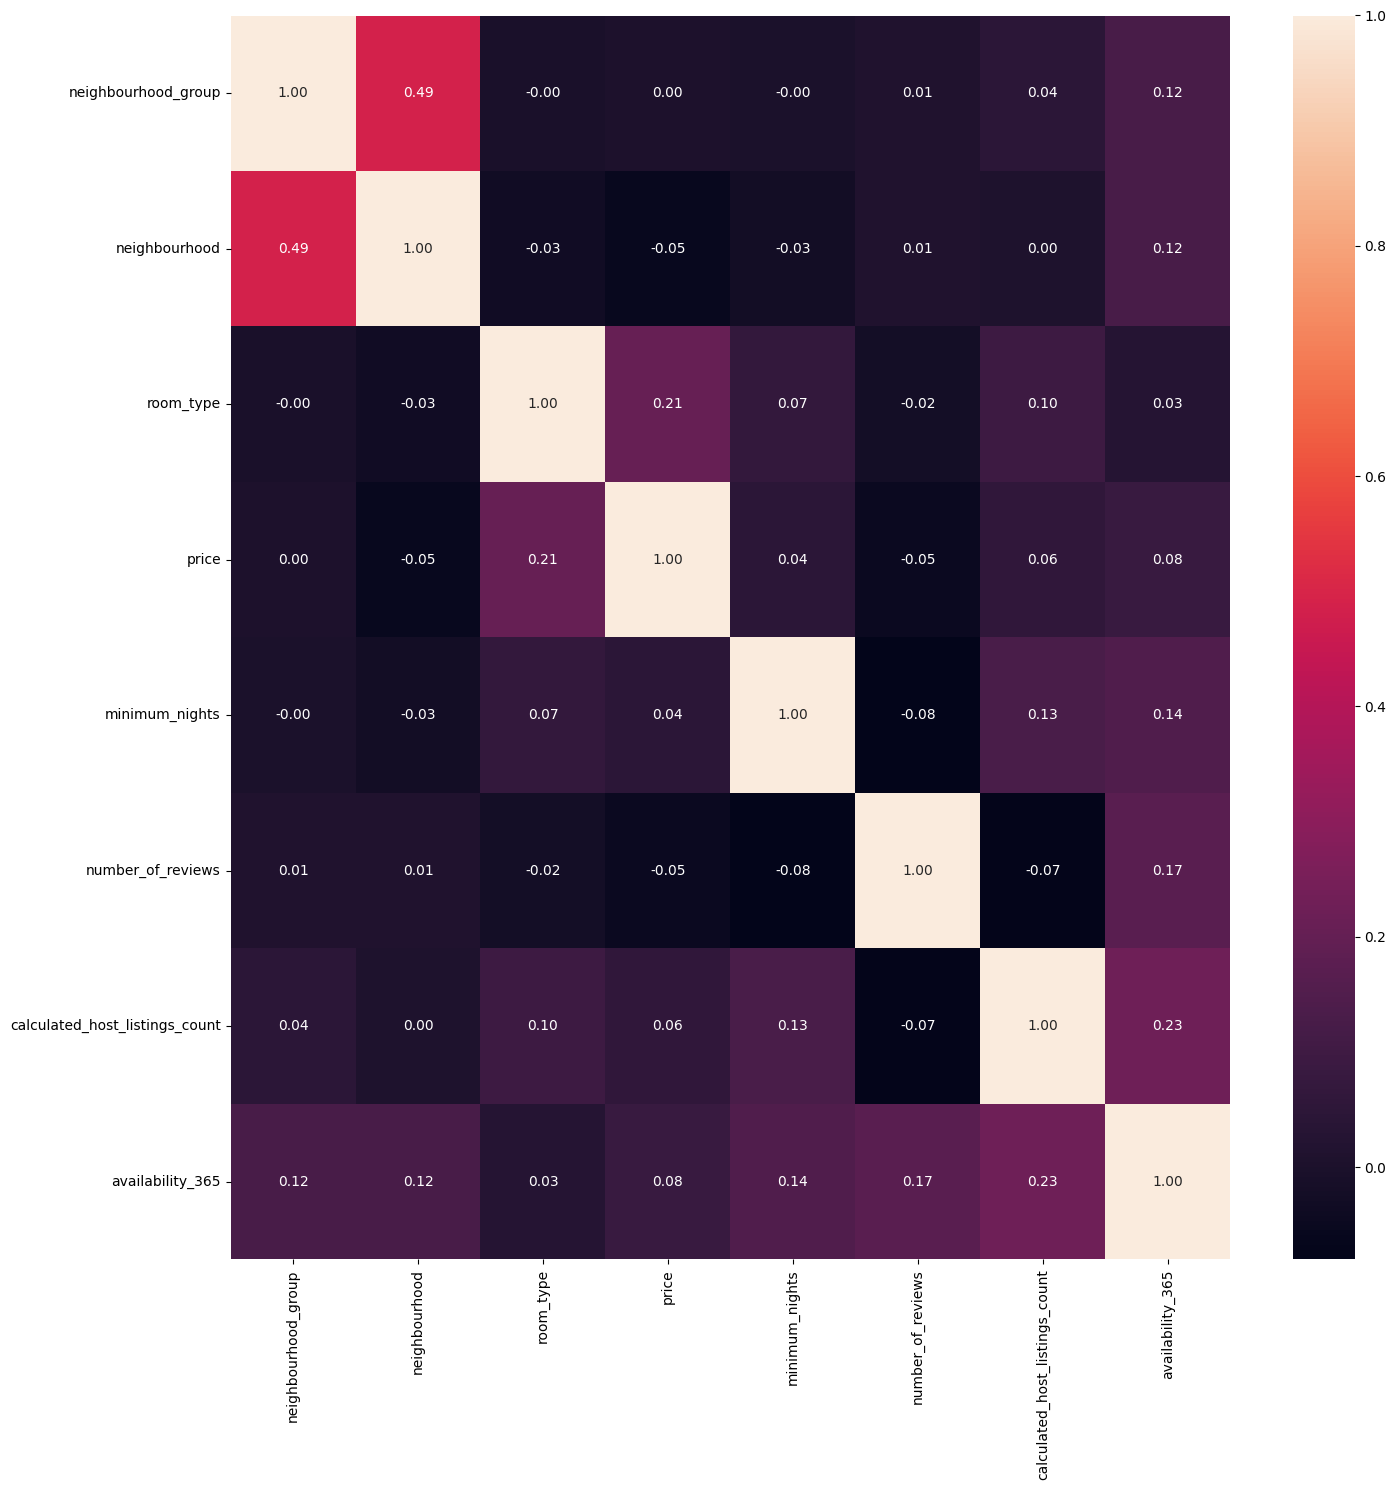

In [166]:
fig, axes = plt.subplots(figsize = (15, 15))

sns.heatmap(data[['neighbourhood_group', 'neighbourhood', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']].corr(), annot = True, fmt = '.2f')

plt.tight_layout()

plt.show()

## Featuring engineering

### Outliers analysis

In [167]:
variables = ['neighbourhood_group', 'price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'room_type']

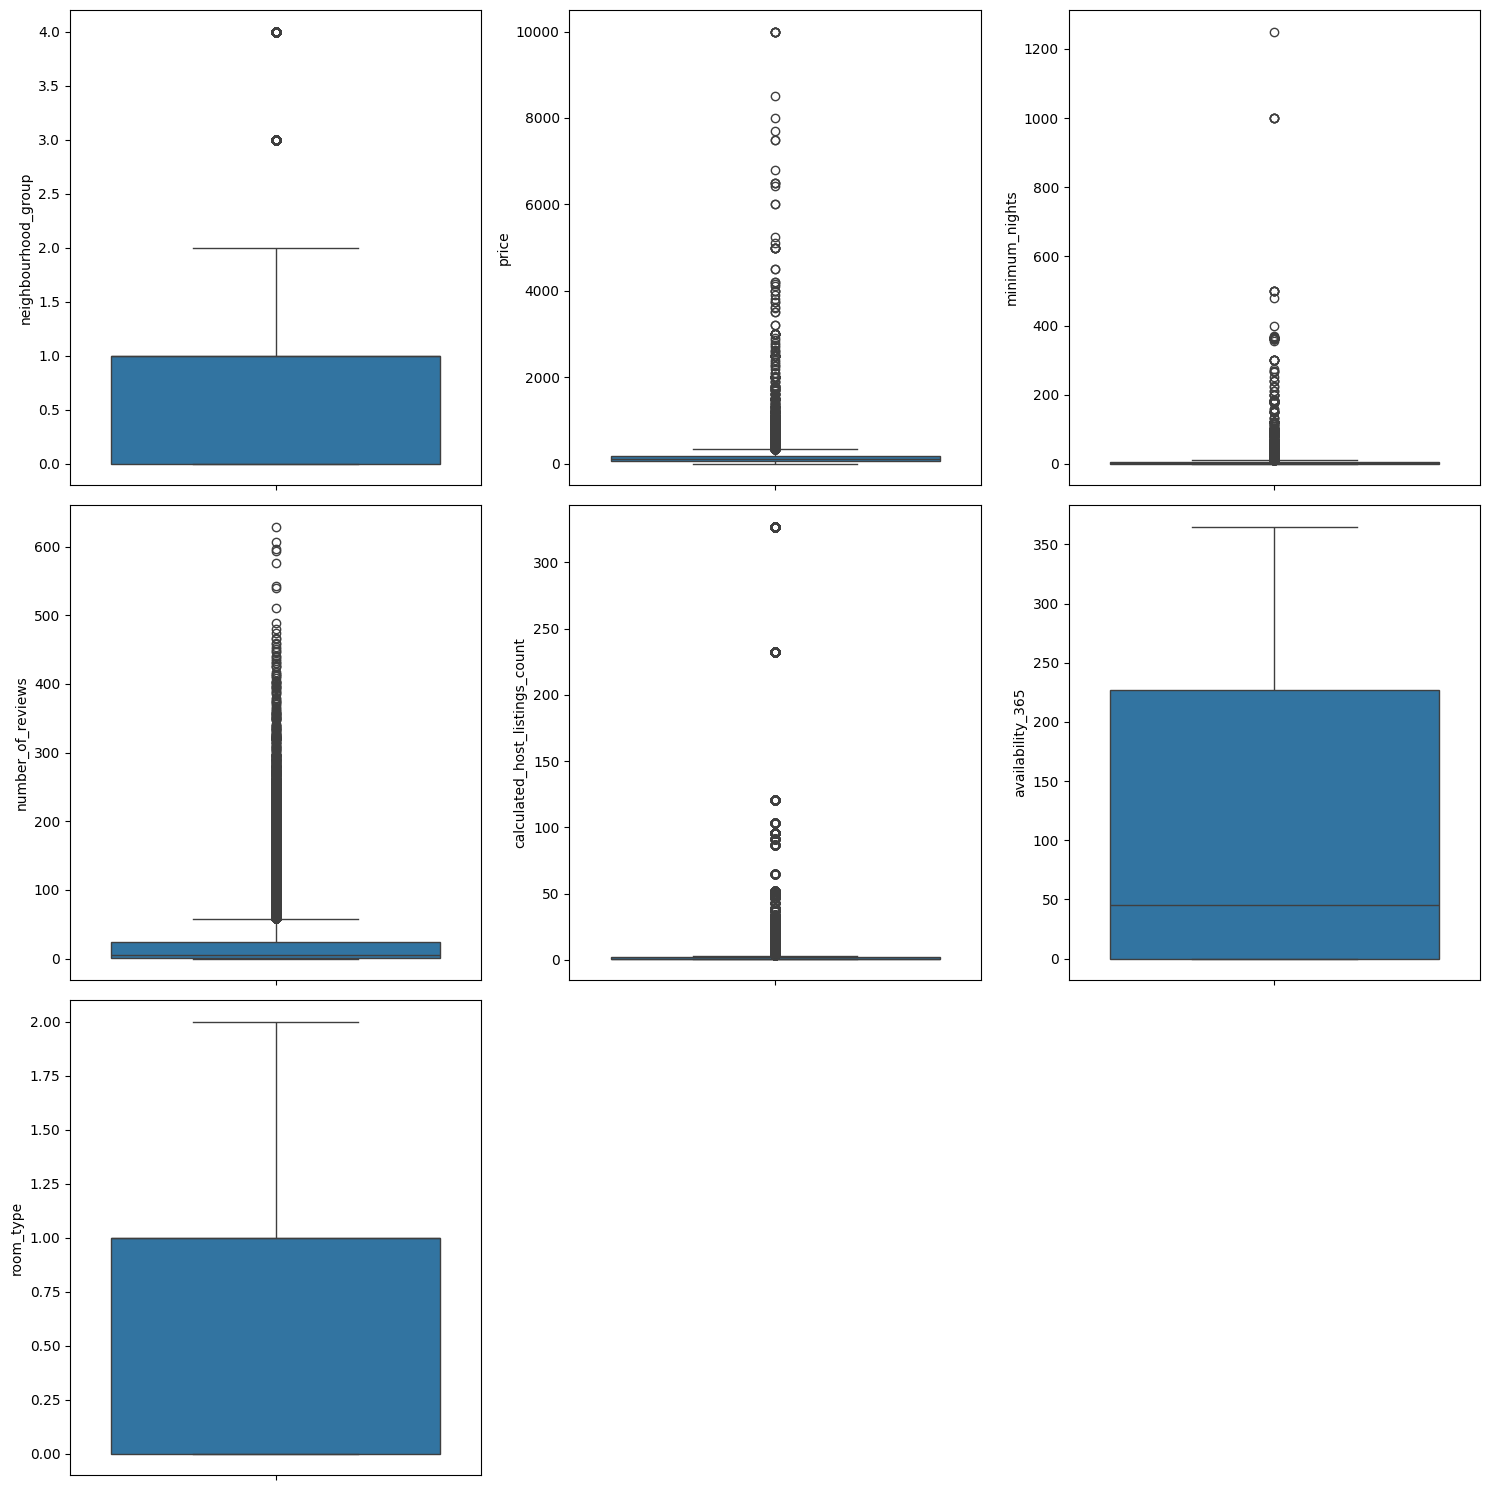

In [168]:
fig, axis = plt.subplots(3, 3, figsize = (15, 15))

sns.boxplot(ax = axis[0, 0], data = data, y = variables[0])
sns.boxplot(ax = axis[0, 1], data = data, y = variables[1])
sns.boxplot(ax = axis[0, 2], data = data, y = variables[2])
sns.boxplot(ax = axis[1, 0], data = data, y = variables[3])
sns.boxplot(ax = axis[1, 1], data = data, y = variables[4])
sns.boxplot(ax = axis[1, 2], data = data, y = variables[5])
sns.boxplot(ax = axis[2, 0], data = data, y = variables[6])

plt.delaxes(axis[2, 1])
plt.delaxes(axis[2, 2])

plt.tight_layout()

plt.show()

In [169]:
import numpy as np

outliers = {}

for col in variables:
  Q1 = np.percentile(data[col], 25)
  Q3 = np.percentile(data[col], 75)
  
  # Obtenemos el rango interquartilico
  IQR = Q3 - Q1
  
  # limite inferior
  lower_bound = Q1 - 1.5 * IQR
  
  # limite superior
  upper_bound = Q3 + 1.5 * IQR
  
  outliers[f'upper_lower_bound_{col}'] = lower_bound, upper_bound

print('Outlier per Column')
outliers

Outlier per Column


{'upper_lower_bound_neighbourhood_group': (-1.5, 2.5),
 'upper_lower_bound_price': (-90.0, 334.0),
 'upper_lower_bound_minimum_nights': (-5.0, 11.0),
 'upper_lower_bound_number_of_reviews': (-33.5, 58.5),
 'upper_lower_bound_calculated_host_listings_count': (-0.5, 3.5),
 'upper_lower_bound_availability_365': (-340.5, 567.5),
 'upper_lower_bound_room_type': (-1.5, 2.5)}

### Missing Values Analysis

In [170]:
100 * data.isnull().sum() / len(data)

neighbourhood_group               0.0
neighbourhood                     0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
dtype: float64

### Feature Scaling

In [171]:
data.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,0,0,0,149,1,9,6,365
1,1,1,1,225,1,45,2,355
2,1,2,0,150,3,0,1,365
3,0,3,1,89,1,270,1,194
4,1,4,1,80,10,9,1,0


In [176]:
# Definimos las variables numéricas que queremos normalizar
numerical_variables = ['number_of_reviews', 'minimum_nights', 'calculated_host_listings_count', 'availability_365', 'neighbourhood_group', 'room_type']

# Creamos una instancia del Normalizer
normalizer = Normalizer()

# Aplicamos el normalizador a las variables numéricas
norm_features = normalizer.fit_transform(data[numerical_variables])

# Convertimos las características normalizadas en un DataFrame de pandas
data_norm = pd.DataFrame(norm_features, index = data.index, columns = numerical_variables)

# Añadimos la columna 'price' al DataFrame normalizado
data_norm['price'] = data['price']

# Mostramos las primeras filas del DataFrame normalizado
data_norm.head()

,number_of_reviews,minimum_nights,calculated_host_listings_count,availability_365,neighbourhood_group,room_type,price
0,0.024647,0.002739,0.016431,0.999557,0.000000,0.000000,149
1,0.125751,0.002794,0.005589,0.992034,0.002794,0.002794,225
2,0.000000,0.008219,0.002740,0.999959,0.002740,0.000000,150
3,0.812093,0.003008,0.003008,0.583504,0.000000,0.003008,89
4,0.663489,0.737210,0.073721,0.000000,0.073721,0.073721,80


## Feature Selection

In [178]:
X = data_norm.drop('price', axis = 1)
y = data_norm['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [179]:
X_train

,number_of_reviews,minimum_nights,calculated_host_listings_count,availability_365,neighbourhood_group,room_type
32645,0.953821,0.260133,0.086711,0.086711,0.000000,0.086711
23615,0.632456,0.632456,0.316228,0.000000,0.316228,0.000000
31183,0.000000,0.707107,0.707107,0.000000,0.000000,0.000000
29260,0.309789,0.010682,0.003561,0.950732,0.000000,0.003561
7275,0.921546,0.354441,0.070888,0.000000,0.141776,0.000000
...,...,...,...,...,...,...
11284,0.000000,0.377964,0.377964,0.000000,0.377964,0.755929
44732,0.052532,0.026266,0.013133,0.998101,0.013133,0.000000
38158,0.003806,0.114168,0.019028,0.993257,0.003806,0.003806
860,0.957427,0.174078,0.087039,0.174078,0.087039,0.087039


In [180]:
X_test

,number_of_reviews,minimum_nights,calculated_host_listings_count,availability_365,neighbourhood_group,room_type
879,0.311656,0.015080,0.005027,0.950049,0.000000,0.005027
44383,0.000000,0.276340,0.013159,0.960609,0.026318,0.000000
15394,0.989778,0.116445,0.058222,0.000000,0.058222,0.000000
43230,0.011754,0.004702,0.768733,0.639436,0.002351,0.002351
16332,0.705736,0.047049,0.023525,0.705736,0.023525,0.023525
...,...,...,...,...,...,...
20477,0.255712,0.028412,0.014206,0.966022,0.014206,0.014206
44969,0.000000,0.003401,0.020404,0.999780,0.003401,0.000000
36577,0.593391,0.118678,0.474713,0.593391,0.237356,0.000000
11477,0.000000,0.755929,0.377964,0.000000,0.377964,0.377964


In [181]:
y_train

32645    295
23615     70
31183     58
29260     75
7275      38
        ... 
11284     60
44732     85
38158    130
860      150
15795    120
Name: price, Length: 39116, dtype: int64

In [182]:
y_test

879       89
44383     30
15394    120
43230    470
16332    199
        ... 
20477    215
44969    100
36577     70
11477    500
1023     125
Name: price, Length: 9779, dtype: int64

In [183]:
selection_model = SelectKBest(chi2, k = 4)

selection_model.fit(X_train, y_train)

ix = selection_model.get_support()

X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

In [184]:
X_train_sel.head()

,number_of_reviews,calculated_host_listings_count,availability_365,room_type
0,0.953821,0.086711,0.086711,0.086711
1,0.632456,0.316228,0.000000,0.000000
2,0.000000,0.707107,0.000000,0.000000
3,0.309789,0.003561,0.950732,0.003561
4,0.921546,0.070888,0.000000,0.000000


### Save the clean and raw data

In [185]:
X_train_sel['price'] = list(y_train)
X_test_sel['price'] = list(y_test)

X_train_sel.to_csv('../processed/clean_train.csv', index = False)
X_test_sel.to_csv('../processed/clean_test.csv', index = False)